In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm 
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchsummary import summary
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b1

# Подготовка тренировочного датасета

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: Tesla P100-PCIE-16GB
PyTorch CUDA version: 12.3
Tensor device: cuda:0


In [5]:
device

device(type='cuda')

In [6]:
pd.read_csv('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [7]:
categories = pd.read_csv('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [8]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [9]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (img_train).
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.files = os.listdir(self.img_dir)
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.files[idx]
        img_id =img_id.split('.')[0]
        # img_id1 = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        # label = self.labels.iloc[idx, 1]  # target_feature (метка)
        label = self.labels.loc[self.labels['img_id'] == int(img_id), 'target_feature'].values[0]

        # Загружаем изображение
        # img_path = os.path.join(self.img_dir, 'aug_'+str(img_id)+'.jpg')
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label, img_id
    
    def __len__(self):
        return len(self.files)


# Создание папки с аугментированными изображениями и ответами к ним

Перед аугментацией, разобъем наш датасет на две части

In [10]:
#Класс для разделения
class SplitPFileToVal:
    def __init__(self, path_to_dir, path_to_new_dir_val, path_to_new_dir_train, p:float):
        """
        Создаёт 2 новые папки: Для валидации - % от всех изображений, для трейна - все остальное. 
        Нужно для отделения части датасета, для val данных

        path_to_dir: Папка с изображениями. (img_train)
        path_to_new_dir_val: Путь до новой папки, можно не создавать вручную.
        path_to_new_dir_train: Путь до новой папки, можно не создавать вручную.
        p: % изображений, которые будут отделены для валидационного датасета
        """

        #Проверка, введеного %
        if not isinstance(p, float):
            raise TypeError("% должен быть float")
        if p <= 0 or p > 1:
            raise ValueError("% должен быть в диапозоне: 0 < p <= 1")
        self.p = p

        self.path_to_dir = path_to_dir
        self.files = os.listdir(self.path_to_dir)
        self.path_to_new_dir_val = path_to_new_dir_val
        self.path_to_new_dir_train = path_to_new_dir_train



        # Создаем папки для сохранения
        if os.path.exists(path_to_new_dir_val):
            shutil.rmtree(path_to_new_dir_val)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_val, exist_ok=True)

        if os.path.exists(path_to_new_dir_train):
            shutil.rmtree(path_to_new_dir_train)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_train, exist_ok=True)

    def split(self):
        len_val = int(len(self.files)*self.p)
        len_train = len(self.files) - len_val
        with tqdm(total=len_val, desc="Отделение валидационных данных", unit="img") as pbar:
            for _ in range(len_val):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_val+f'/{file}')
                self.files.pop(idx)

                pbar.update(1)

        with tqdm(total=len_train, desc="Отделение тренировочных данных", unit="img") as pbar:
            for _ in range(len_train):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_train+f'/{file}')
                self.files.pop(idx)
                
                pbar.update(1)

        print(f"\nОтделено {len_val} изображений, для валидации в папку: {self.path_to_new_dir_val}")
        print(f"Отделено {len_train} изображений, для тренировки в папку: {self.path_to_new_dir_train}")



In [11]:
#Использование разделения
spliter = SplitPFileToVal(
    path_to_dir='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/img_train',
    path_to_new_dir_val='/kaggle/working/data/val_dataset',
    path_to_new_dir_train='/kaggle/working/data/train_dataset',
    p=0.1
)

spliter.split()

Отделение тренировочных данных: 100%|██████████| 11131/11131 [02:40<00:00, 69.46img/s]


Отделено 1236 изображений, для валидации в папку: /kaggle/working/data/val_dataset
Отделено 11131 изображений, для тренировки в папку: /kaggle/working/data/train_dataset


In [12]:
#Класс для создания аугментаций
class AugmentedDatasetSaver:
    def __init__(self, original_train_dataset, csv_path, augmentation_transform, new_train_dataset_path, output_csv_path, augment_count):
        """
        Создает и сохраняет аугментированный датасет из тренировочного.
        Также создает csv с ответами на аугментированный датасет, сохраняет ответы из train_answers

        original_train_dataset: Исходный датасет (torch Dataset).
        csv_path: путь к csv с ответами
        augmentation_transform: Трансформации для аугментации.
        new_train_dataset_path: Папка, куда будут сохранены данные.
        output_csv_path: Путь, куда будет сохранена csv
        augment_count: Количество аугментированных изображений, которые нужно создать.
        """
        self.original_train_dataset_path = original_train_dataset
        self.augmentation_transform = augmentation_transform
        self.new_train_dataset_path = new_train_dataset_path
        self.output_csv_path = output_csv_path
        self.original_labels = pd.read_csv(csv_path)

        
        if augment_count >= len(original_train_dataset):
            print("Введеный augment_count > длины датасета")
        self.augment_count = augment_count


        # Создаем папку для сохранения
        if os.path.exists(new_train_dataset_path):
            shutil.rmtree(new_train_dataset_path)  # Удаляем папку, если она уже существует
        os.makedirs(new_train_dataset_path, exist_ok=True)

    def save(self):
        new_entries = []
        max_id = self.original_labels['img_id'].max()
        with tqdm(total=self.augment_count, desc="Создание аугментированных данных", unit="img") as pbar:
            for i in range(self.augment_count):
                # Выбираем случайное изображение из оригинального датасета
                image, label, img_id = random.choice(self.original_train_dataset_path)

                # Преобразуем в тензор, если это PIL.Image
                if not isinstance(image, Image.Image):
                    raise ValueError(f"Unsupported image format: {type(image)}")

                # Применяем аугментацию
                augmented_image = self.augmentation_transform(image)

                

                # Генерируем имя файла, сохраняя оригинальное имя с префиксом
                img_id = max_id+i+1

                new_entries.append({'img_id': int(img_id), 'target_feature': label})

                img_save_path = os.path.join(self.new_train_dataset_path, f"{img_id}.jpg")

                # Преобразуем аугментированный тензор обратно в PIL.Image и сохраняем
                augmented_image = transforms.ToPILImage()(augmented_image)  # Перевод тензора в PIL
                augmented_image.save(img_save_path)

                pbar.update(1)
        # Создание DataFrame для новых данных
        augmented_df = pd.DataFrame(new_entries)
        combined_df = pd.concat([self.original_labels, augmented_df], ignore_index=True)
        combined_df.to_csv(self.output_csv_path, index=False)
        
        print(f"CSV файл с метками успешно сохранён в: {self.output_csv_path}")
        print(f"\nСохранено {self.augment_count} аугментированных изображений в папке: {self.new_train_dataset_path}")


In [13]:
#transform для аугментации
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=25), 
    transforms.ToTensor(),  # Преобразование в тензор для работы с RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

In [14]:
# Загружаем датасет, для тренировки
original_traint_dataset = HumanPoseDataset(
    img_dir='/kaggle/working/data/train_dataset',
    csv_file='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv',
    transform=None  # Оставляем без изменений
)

# Папка для сохранения аугментированного датасета
save_dir = "/kaggle/working/data/augmented_only_dataset"

# Количество аугментированных изображений
augment_count = 11000 

# Создаем и сохраняем 
dataset_saver = AugmentedDatasetSaver(
    original_train_dataset=original_traint_dataset,
    augmentation_transform=augmentation_transform,
    csv_path='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv',
    new_train_dataset_path=save_dir,
    augment_count=augment_count,
    output_csv_path='/kaggle/working/data/augmented_train_answers.csv'
)

In [15]:
# Создание аугментированных файлов
dataset_saver.save()

Создание аугментированных данных: 100%|██████████| 11000/11000 [04:40<00:00, 39.27img/s]


CSV файл с метками успешно сохранён в: /kaggle/working/data/augmented_train_answers.csv

Сохранено 11000 аугментированных изображений в папке: /kaggle/working/data/augmented_only_dataset


Проверка, что все создалось в нужном кол-ве

In [16]:
line_count = sum(1 for line in open('/kaggle/working/data/augmented_train_answers.csv')) - sum(1 for line in open('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv'))
if augment_count == line_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {line_count}(line_count)')

OK


In [17]:
aug_file_count = len(os.listdir("/kaggle/working/data/augmented_only_dataset"))
if augment_count == aug_file_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {aug_file_count}(aug_file_count)')

OK


## Cоединение папки с аугментированными картинками и тренировочным датасетом в новую папку.

Удаляет папку по пути, который указан в path_augmented_only_dataset

In [18]:
def merge_folders(path_train_dataset, path_augmented_only_dataset, path_destination_folder):
    """
    Объединяет две папки с картинками в одну. УДАЛЯЕТ папку path_augmented_only_dataset

    :param path_train_dataset: Путь к первой исходной папке
    :param source_folder2: Путь ко второй исходной папке
    :param destination_folder: Путь к папке назначения
    """
    # Создаем папку назначения, если она не существует
    if os.path.exists(path_destination_folder):
        shutil.rmtree(path_destination_folder)  # Удаляем папку, если она уже существует
    os.makedirs(path_destination_folder, exist_ok=True)
    
    # Функция для копирования файлов из папки
    def copy_files_from_folder(folder):
        with tqdm(total=len(os.listdir(folder)), desc=f"Копирование из {folder}", unit="img") as pbar:
            for file_name in os.listdir(folder):
                source_path = os.path.join(folder, file_name)
                dest_path = os.path.join(path_destination_folder, file_name)
                
                # Проверяем, является ли элемент файлом
                if os.path.isfile(source_path):
                    if os.path.exists(dest_path):
                        raise KeyError('файл с таким именем уже существует в папке назначения')
                    shutil.copy2(source_path, dest_path)
                pbar.update(1)
    
    # Копируем файлы из обеих папок
    copy_files_from_folder(path_train_dataset)
    copy_files_from_folder(path_augmented_only_dataset)
    #Удаляем папку с аугментацией
    shutil.rmtree(path_augmented_only_dataset)

In [19]:
path_train_dataset = '/kaggle/working/data/train_dataset'
path_augmented_only_dataset = "/kaggle/working/data/augmented_only_dataset"
destination_folder = "/kaggle/working/data/augmented_and_train_dataset"

In [20]:
merge_folders(path_train_dataset, path_augmented_only_dataset, destination_folder)

Копирование из /kaggle/working/data/train_dataset: 100%|██████████| 11131/11131 [00:09<00:00, 1236.53img/s]
Копирование из /kaggle/working/data/augmented_only_dataset: 100%|██████████| 11000/11000 [00:01<00:00, 7557.55img/s]


In [21]:
expected_count = aug_file_count+len(os.listdir("/kaggle/working/data/train_dataset"))
quantity_count = len(os.listdir("/kaggle/working/data/augmented_and_train_dataset"))
if expected_count == quantity_count:
    print('OK')
else:
    print(f'Ожидалось {expected_count}(expected_count)\n Получилось {quantity_count}(quantity_count)')

OK


По итогу получилось:   
папка img_train -- картинки в оригинале,  
папка train_dataset -- часть датасета, для обучения,  
папка val_dataset -- часть датасета, для валидации,   
папка augmented_and_train_dataset -- augmented_only_dataset+img_train,   
augmented_train_answers.csv -- ответы на все папки  

# Начало работы с моделью

In [22]:
# RANDOM_SEED = 52
# generator = torch.Generator().manual_seed(RANDOM_SEED)

In [23]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 4


In [24]:
# transform_train = transforms.Compose([
#     transforms.Resize((227, 227)), # тк в ауг датасете есть фото без аугментации
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [25]:
val_dataset = HumanPoseDataset(
    img_dir='/kaggle/working/data/val_dataset',
    csv_file='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv',
    transform=transform
)

train_dataset = HumanPoseDataset(
    img_dir='/kaggle/working/data/augmented_and_train_dataset',
    csv_file='/kaggle/working/data/augmented_train_answers.csv',
    transform=transform
)



# train_dataset, _ = random_split(dataset_train, [int(0.9*len(dataset_train)), len(dataset_train) - int(0.9*len(dataset_train))], generator)
# _, val_dataset = random_split(dataset_val, [int(0.9*len(dataset_val)), len(dataset_val) - int(0.9*len(dataset_val))], generator)

In [26]:
import pandas as pd

# Загрузим CSV-файлы для валидационного и тренировочного датасетов
val_labels_df = pd.read_csv('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv')
train_labels_df = pd.read_csv('/kaggle/working/data/augmented_train_answers.csv')

# Предположим, что метки классов в этих датафреймах хранятся в колонке 'label' или другой
# Замените 'label' на название колонки с метками в вашем случае
val_labels = val_labels_df['target_feature'].values
train_labels = train_labels_df['target_feature'].values

# Подсчитаем количество примеров для каждого класса в тренировочном датасете
train_class_counts = pd.Series(train_labels).value_counts().sort_index().to_dict()

# Подсчитаем количество примеров для каждого класса в валидационном датасете
val_class_counts = pd.Series(val_labels).value_counts().sort_index().to_dict()

# Выведем количество примеров для каждого класса
print(f"Train class counts:\n{train_class_counts}")
print(f"Validation class counts:\n{val_class_counts}")


Train class counts:
{0: 4735, 1: 258, 2: 996, 3: 3188, 4: 1353, 5: 1867, 6: 1514, 8: 1021, 9: 2325, 10: 727, 11: 1021, 12: 878, 13: 889, 14: 472, 16: 1389, 18: 734}
Validation class counts:
{0: 2512, 1: 135, 2: 530, 3: 1680, 4: 752, 5: 982, 6: 800, 8: 533, 9: 1223, 10: 390, 11: 528, 12: 469, 13: 442, 14: 228, 16: 753, 18: 410}


In [27]:
total_train_samples = sum(train_class_counts.values())
total_val_samples = sum(val_class_counts.values())

# Веса для классов в тренировочном и валидационном датасетах
train_class_weights = {k: total_train_samples / v for k, v in train_class_counts.items()}
val_class_weights = {k: total_val_samples / v for k, v in val_class_counts.items()}

# Выводим веса для классов
print("Train class weights:", train_class_weights)
print("Validation class weights:", val_class_weights)

Train class weights: {0: 4.934952481520591, 1: 90.56976744186046, 2: 23.460843373493976, 3: 7.329673776662484, 4: 17.27050997782705, 5: 12.515800749866095, 6: 15.433949801849405, 8: 22.886385896180215, 9: 10.050322580645162, 10: 32.141678129298484, 11: 22.886385896180215, 12: 26.613895216400913, 13: 26.28458942632171, 14: 49.50635593220339, 16: 16.822894168466522, 18: 31.83514986376022}
Validation class weights: {0: 4.923168789808917, 1: 91.60740740740741, 2: 23.333962264150944, 3: 7.361309523809524, 4: 16.445478723404257, 5: 12.59368635437882, 6: 15.45875, 8: 23.202626641651033, 9: 10.112019623875716, 10: 31.71025641025641, 11: 23.422348484848484, 12: 26.368869936034116, 13: 27.979638009049772, 14: 54.24122807017544, 16: 16.42363877822045, 18: 30.163414634146342}


In [28]:
train_dataset[0]

(tensor([[[-0.4226, -0.4568, -0.5082,  ...,  0.3652,  0.4166,  0.4337],
          [-0.4397, -0.4739, -0.5082,  ...,  0.3823,  0.4166,  0.4337],
          [-0.4568, -0.4739, -0.5082,  ...,  0.3823,  0.4337,  0.4337],
          ...,
          [ 0.7933,  0.7419,  0.6392,  ...,  0.3652,  0.3481,  0.3994],
          [ 0.7419,  0.7248,  0.6563,  ...,  0.3138,  0.3138,  0.3481],
          [ 0.6906,  0.7419,  0.6563,  ...,  0.2967,  0.2967,  0.3652]],
 
         [[-0.3025, -0.3375, -0.3550,  ...,  0.5553,  0.5553,  0.5728],
          [-0.2850, -0.3200, -0.3550,  ...,  0.5553,  0.5553,  0.5728],
          [-0.2850, -0.3025, -0.3550,  ...,  0.5728,  0.5728,  0.5728],
          ...,
          [ 0.6254,  0.5728,  0.5203,  ...,  0.3277,  0.3277,  0.3627],
          [ 0.5903,  0.5728,  0.5378,  ...,  0.3102,  0.3277,  0.3627],
          [ 0.5553,  0.6078,  0.5378,  ...,  0.3277,  0.3277,  0.3978]],
 
         [[ 0.1825,  0.1651,  0.1302,  ...,  0.8971,  0.9145,  0.9319],
          [ 0.1999,  0.1651,

In [29]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label, img_id= dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

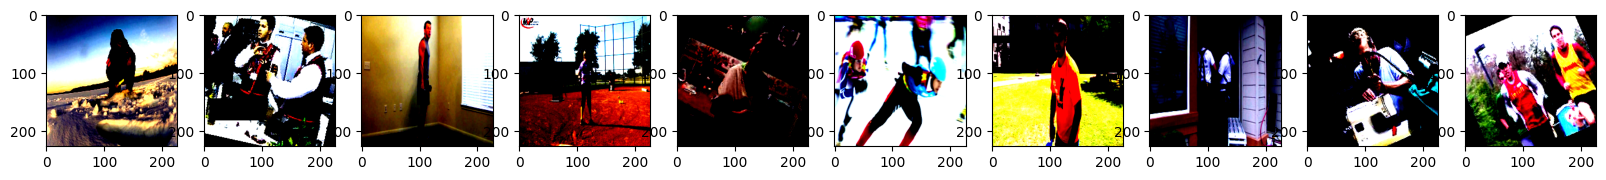

In [30]:
# Вывести первые 5 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category, 10)

# Архитектуры

In [31]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.5):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.3):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.3):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)


In [32]:
import torch.nn.functional as F
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.2):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.2):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.2):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)

In [33]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0
from torchsummary import summary

In [52]:
import torch
import torch.nn as nn
from torchvision import models

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=20):
        super(CustomEfficientNet, self).__init__()

        # Загрузка базовой модели EfficientNet-B0 без предобученных весов
        self.base_model = models.efficientnet_b0(pretrained=False)

        # Добавление дополнительных сверточных слоев и Batch Normalization
        # Сначала добавляем дополнительные сверточные слои и Batch Normalization
        self.extra_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Обновляем первый слой базовой модели для использования 64 каналов (после добавленных слоев)
        self.base_model.features[0][0] = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)

        # Заменяем последний классификатор для 20 классов
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),  # Увеличиваем dropout
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        # Применяем дополнительные слои перед базовой моделью
        x = self.extra_conv(x)
        
        # Дальше передаем результат в базовую модель
        return self.base_model(x)

def custom_efficientnet_b0(num_classes=20):
    return CustomEfficientNet(num_classes=num_classes)


In [53]:
model = CustomEfficientNetLite0(num_classes=20)

In [54]:
len(id_to_category)

20

In [55]:
model = custom_efficientnet_b0(num_classes=20)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (3, 227, 227))

dummy_input = torch.randn(1, 3, 227, 227).to(device)

output = model(dummy_input)
print(output.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 227, 227]             896
       BatchNorm2d-2         [-1, 32, 227, 227]              64
              ReLU-3         [-1, 32, 227, 227]               0
            Conv2d-4         [-1, 64, 227, 227]          18,496
       BatchNorm2d-5         [-1, 64, 227, 227]             128
              ReLU-6         [-1, 64, 227, 227]               0
            Conv2d-7         [-1, 32, 114, 114]          18,464
       BatchNorm2d-8         [-1, 32, 114, 114]              64
              SiLU-9         [-1, 32, 114, 114]               0
           Conv2d-10         [-1, 32, 114, 114]             288
      BatchNorm2d-11         [-1, 32, 114, 114]              64
             SiLU-12         [-1, 32, 114, 114]               0
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
           Conv2d-14              [-1, 

In [38]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging
from ignite.metrics import Precision, Recall

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [39]:
model = custom_efficientnet_b0().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [40]:
# Определение функции потерь и оптимизатора
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

In [41]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=15, tm_hour=17, tm_min=2, tm_sec=57, tm_wday=6, tm_yday=350, tm_isdst=0)

In [42]:
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',  # Или 'max', если метрика должна увеличиваться
#     factor=0.75,  # Во сколько раз уменьшать learning rate
#     patience=1,  # Сколько эпох ждать улучшений
#     verbose=True,  # Выводить сообщения о снижении learning rate
#     min_lr=1e-6  # Минимальное значение learning rate
# )

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [43]:
import os
import time
import logging
import pandas as pd
import torch
from ignite.engine import Engine, Events
from ignite.metrics import Precision, Recall, Loss, MetricsLambda
from ignite.handlers import EarlyStopping, Checkpoint, DiskSaver, global_step_from_engine
from ignite.contrib.handlers import ProgressBar


# Функция для вычисления взвешенного F1
def weighted_f1_from_tensor(f1_tensor, class_weights):
    # Преобразуем веса классов в список
    class_weights_tensor = torch.tensor([class_weights.get(i, 0) for i in range(len(f1_tensor))], dtype=torch.float32)

    # Массив F1 для классов, которые присутствуют в данных
    f1_values = f1_tensor[class_weights_tensor > 0]  # Фильтруем классы с нулевыми весами
    class_weights_values = class_weights_tensor[class_weights_tensor > 0]

    if len(f1_values) == 0:  # Если нет классов с ненулевыми весами
        return 0.0

    # Рассчитываем взвешенный F1
    weighted_f1 = torch.sum(f1_values * class_weights_values) / torch.sum(class_weights_values)
    return weighted_f1.item()

# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()
    images, labels, img_id = batch
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels, img_id = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return {"outputs": outputs, "labels": labels}

# Создаём движки для тренировки и валидации
trainer = Engine(train_step)
evaluator = Engine(val_step)

# Определяем метрики Precision, Recall и F1
precision = Precision(average=False, output_transform=lambda x: (x["outputs"], x["labels"]))
recall = Recall(average=False, output_transform=lambda x: (x["outputs"], x["labels"]))
f1 = MetricsLambda(lambda p, r: 2 * (p * r) / (p + r + 1e-9), precision, recall)

# Добавляем метрики к тренеру и валидатору
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")
precision.attach(trainer, "precision")
recall.attach(trainer, "recall")
f1.attach(trainer, "F1")

eval_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
eval_loss.attach(evaluator, "loss")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "F1")

# Обработчик ранней остановки
handler = EarlyStopping(
    patience=10,
    score_function=lambda engine: -engine.state.metrics["loss"],  # Отслеживаем метрику потерь
    trainer=trainer,
    min_delta=0.01
)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Прогресс-бар
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

# Логирование
cur_time = time.localtime()
path_suf = f'_{cur_time.tm_mday}_{cur_time.tm_mon}_{cur_time.tm_hour}_{cur_time.tm_min}'

log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "training.log"),
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
)
logger = logging.getLogger()

# Сохраняем метрики в DataFrame
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    metrics_df = pd.read_csv(metrics_path)
else:
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train F1", "Validation Loss", "Validation F1"])

# Сохранение модели
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
checkpoint_handler = Checkpoint(
    to_save,
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),
    n_saved=3,
    filename_prefix="best",
    score_function=lambda engine: weighted_f1_from_tensor(engine.state.metrics["F1"], train_class_weights),  # Применяем weighted F1
    score_name="val_F1",
    global_step_transform=global_step_from_engine(trainer),
)


@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Логируем метрики тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_F1 = train_metrics["F1"]

    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_F1 = val_metrics["F1"]
    
    # Рассчитываем взвешенные F1
    weighted_train_f1 = weighted_f1_from_tensor(train_F1, train_class_weights)
    weighted_val_f1 = weighted_f1_from_tensor(val_F1, val_class_weights)


    # Логируем результаты
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Weighted F1: {weighted_train_f1:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Weighted F1: {weighted_val_f1:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Weighted F1: {weighted_train_f1:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Weighted F1: {weighted_val_f1:.4f}")

    # Сохраняем метрики в DataFrame
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train F1": [train_F1],
            "Validation Loss": [val_loss],
            "Validation F1": [val_F1],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)

    # Сохраняем модель
    checkpoint_handler(evaluator)

# Логируем изменения learning rate и weight decay
@trainer.on(Events.EPOCH_COMPLETED)
def log_lr_and_threshold(engine):
    current_lr = optimizer.param_groups[0]["lr"]
    logger.info(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}")
    print(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}")


/opt/conda/lib/python3.10/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [44]:
# weight_decay = 1e-4
trainer.run(train_loader, max_epochs=50)

# Полный output обучения можно посмотреть в traning.log

[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 1: Train Loss: 2.5397, Train Weighted F1: 0.0574, Validation Loss: 2.4373, Validation Weighted F1: 0.0746
Epoch 1: Learning Rate: 0.001000


/tmp/ipykernel_23/1115028416.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 2: Train Loss: 2.3228, Train Weighted F1: 0.1054, Validation Loss: 2.2057, Validation Weighted F1: 0.1470
Epoch 2: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 3: Train Loss: 2.2170, Train Weighted F1: 0.1439, Validation Loss: 2.2446, Validation Weighted F1: 0.1512
Epoch 3: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 4: Train Loss: 2.1228, Train Weighted F1: 0.1768, Validation Loss: 2.0886, Validation Weighted F1: 0.1814
Epoch 4: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 5: Train Loss: 2.0317, Train Weighted F1: 0.2182, Validation Loss: 2.0391, Validation Weighted F1: 0.2155
Epoch 5: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 6: Train Loss: 1.9318, Train Weighted F1: 0.2702, Validation Loss: 1.9812, Validation Weighted F1: 0.2635
Epoch 6: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 7: Train Loss: 1.8360, Train Weighted F1: 0.3175, Validation Loss: 1.9040, Validation Weighted F1: 0.2767
Epoch 7: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 8: Train Loss: 1.7268, Train Weighted F1: 0.3596, Validation Loss: 1.8358, Validation Weighted F1: 0.3490
Epoch 8: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 9: Train Loss: 1.6175, Train Weighted F1: 0.4145, Validation Loss: 1.7600, Validation Weighted F1: 0.3766
Epoch 9: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 10: Train Loss: 1.4974, Train Weighted F1: 0.4629, Validation Loss: 1.7286, Validation Weighted F1: 0.3795
Epoch 10: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 11: Train Loss: 1.3805, Train Weighted F1: 0.5338, Validation Loss: 1.7038, Validation Weighted F1: 0.4067
Epoch 11: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 12: Train Loss: 1.2788, Train Weighted F1: 0.5914, Validation Loss: 1.6719, Validation Weighted F1: 0.4702
Epoch 12: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 13: Train Loss: 1.1671, Train Weighted F1: 0.6685, Validation Loss: 1.6637, Validation Weighted F1: 0.4575
Epoch 13: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 14: Train Loss: 1.0667, Train Weighted F1: 0.7279, Validation Loss: 1.7170, Validation Weighted F1: 0.4943
Epoch 14: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 15: Train Loss: 0.9929, Train Weighted F1: 0.7798, Validation Loss: 1.6639, Validation Weighted F1: 0.5075
Epoch 15: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 16: Train Loss: 0.9285, Train Weighted F1: 0.8347, Validation Loss: 1.6680, Validation Weighted F1: 0.5233
Epoch 16: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 17: Train Loss: 0.8874, Train Weighted F1: 0.8584, Validation Loss: 1.6209, Validation Weighted F1: 0.5469
Epoch 17: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 18: Train Loss: 0.8236, Train Weighted F1: 0.9060, Validation Loss: 1.6281, Validation Weighted F1: 0.5465
Epoch 18: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 19: Train Loss: 0.7965, Train Weighted F1: 0.9221, Validation Loss: 1.6058, Validation Weighted F1: 0.5218
Epoch 19: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 20: Train Loss: 0.7767, Train Weighted F1: 0.9356, Validation Loss: 1.5934, Validation Weighted F1: 0.5349
Epoch 20: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 21: Train Loss: 0.7641, Train Weighted F1: 0.9465, Validation Loss: 1.7005, Validation Weighted F1: 0.5183
Epoch 21: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 22: Train Loss: 0.7501, Train Weighted F1: 0.9564, Validation Loss: 1.6669, Validation Weighted F1: 0.4798
Epoch 22: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 23: Train Loss: 0.7472, Train Weighted F1: 0.9564, Validation Loss: 1.6508, Validation Weighted F1: 0.5473
Epoch 23: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 24: Train Loss: 0.7386, Train Weighted F1: 0.9533, Validation Loss: 1.6673, Validation Weighted F1: 0.5064
Epoch 24: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 25: Train Loss: 0.7383, Train Weighted F1: 0.9565, Validation Loss: 1.6421, Validation Weighted F1: 0.5238
Epoch 25: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 26: Train Loss: 0.7218, Train Weighted F1: 0.9672, Validation Loss: 1.6402, Validation Weighted F1: 0.5540
Epoch 26: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 27: Train Loss: 0.7201, Train Weighted F1: 0.9668, Validation Loss: 1.6265, Validation Weighted F1: 0.5195
Epoch 27: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 28: Train Loss: 0.7192, Train Weighted F1: 0.9650, Validation Loss: 1.5990, Validation Weighted F1: 0.5280
Epoch 28: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

Epoch 29: Train Loss: 0.7090, Train Weighted F1: 0.9706, Validation Loss: 1.5937, Validation Weighted F1: 0.5659
Epoch 29: Learning Rate: 0.001000


[1/346]   0%|           [00:00<?]

[1/20]   5%|5          [00:00<?]

2024-12-15 18:23:02,364 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 30: Train Loss: 0.7008, Train Weighted F1: 0.9644, Validation Loss: 1.6133, Validation Weighted F1: 0.5144
Epoch 30: Learning Rate: 0.001000


State:
	iteration: 10380
	epoch: 30
	epoch_length: 346
	max_epochs: 50
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [46]:
import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image

model = custom_efficientnet_b0(num_classes=20).to(device)
checkpoint_path = "/kaggle/working/train_info/checkpoints_15_12_17_2/best_checkpoint_29_val_F1=0.5694.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model"])
model.eval()  

test_images_path = "/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/img_test"

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_image_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

results = []

for image_file in test_image_files:
    image_path = os.path.join(test_images_path, image_file)
    image = Image.open(image_path).convert("RGB") 
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        predicted_class = torch.argmax(outputs, dim=1).item() 

    image_id = os.path.splitext(image_file)[0]
    results.append({"id": image_id, "target_feature": predicted_class})

submission_df = pd.DataFrame(results)

submission_file_path = "/kaggle/working/best_checkpoint_29_val_F1=0.5694.pt.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to: {submission_file_path}")


/tmp/ipykernel_23/3062710950.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Submission file saved to: /kaggle/working/best_checkpoint_29_val_F1=0.5694.pt.csv
